<a href="https://colab.research.google.com/github/saktiworkstation/road-to-ai-developer/blob/main/GNN_(Teacher_Student)_%2B_Knowledge_Distillation_%2B_BART_Summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch-geometric
!pip install transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 26.2 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv

from transformers import BartForConditionalGeneration, BartTokenizer

In [3]:
dataset_name = 'CiteSeer'
dataset = Planetoid(root='data/CiteSeer', name=dataset_name)

data = dataset[0]

Processing...
Done!


In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [4]:
print("===== INFORMASI DATASET =====")
print(f"Nama Dataset      : {dataset_name}")
print(f"Jumlah Graph      : {len(dataset)}")
print(f"Jumlah Fitur      : {dataset.num_features}")
print(f"Jumlah Kelas      : {dataset.num_classes}")
print(f"Jumlah Node       : {data.num_nodes}")
print(f"Jumlah Edge       : {data.num_edges}")
print(f"Average Node Degree : {data.num_edges / data.num_nodes:.2f}")
print(f"Jumlah Training Nodes : {data.train_mask.sum().item()}")
print(f"Jumlah Validation Nodes : {data.val_mask.sum().item()}")
print(f"Jumlah Test Nodes : {data.test_mask.sum().item()}\n")

===== INFORMASI DATASET =====
Nama Dataset      : CiteSeer
Jumlah Graph      : 1
Jumlah Fitur      : 3703
Jumlah Kelas      : 6
Jumlah Node       : 3327
Jumlah Edge       : 9104
Average Node Degree : 2.74
Jumlah Training Nodes : 120
Jumlah Validation Nodes : 500
Jumlah Test Nodes : 1000



In [6]:
labels = data.y
unique_labels, counts_labels = torch.unique(labels, return_counts=True)
print("\n=== DISTRIBUSI KELAS ===")
for lab, count in zip(unique_labels, counts_labels):
    print(f"Kelas {lab.item()}: {count.item()} node")

print("\n=== EDGE SAMPLE ===")
print(data.edge_index[:, :10])


=== DISTRIBUSI KELAS ===
Kelas 0: 264 node
Kelas 1: 590 node
Kelas 2: 668 node
Kelas 3: 701 node
Kelas 4: 596 node
Kelas 5: 508 node

=== EDGE SAMPLE ===
tensor([[ 628,  158,  486, 1097, 2919, 2933, 3285, 1431, 3219,  467],
        [   0,    1,    1,    1,    1,    1,    2,    3,    3,    4]])


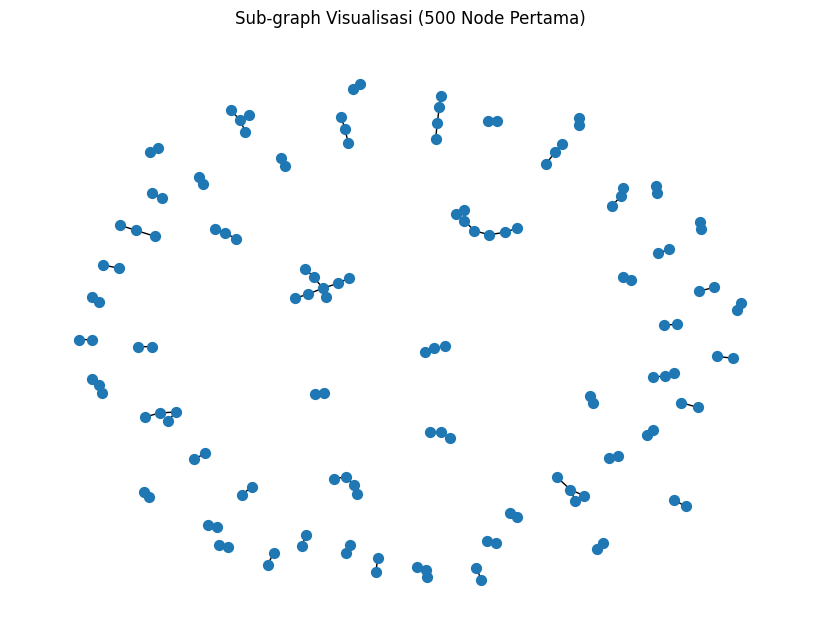

In [7]:
import matplotlib.pyplot as plt
import networkx as nx

sub_node_count = 500
sub_edge_mask = (data.edge_index[0] < sub_node_count) & (data.edge_index[1] < sub_node_count)
sub_edge_index = data.edge_index[:, sub_edge_mask]

sub_G = nx.Graph()
sub_edges = list(zip(sub_edge_index[0].tolist(), sub_edge_index[1].tolist()))
sub_G.add_edges_from(sub_edges)

plt.figure(figsize=(8, 6))
nx.draw(sub_G, node_size=50)
plt.title("Sub-graph Visualisasi (500 Node Pertama)")
plt.show()

# Model GCN

**Teacher GNN (5 Lapisan GCN)**

In [13]:
class TeacherGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(TeacherGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x  # logits (belum softmax)

**Student GNN (2 Lapisan GCN)**

In [14]:
class StudentGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(StudentGCN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x  # logits (belum softmax)

# TRAINING & EVALUATION

In [15]:
def evaluate(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    preds = logits.argmax(dim=1)

    accs = []
    for mask_name, mask in zip(
        ["Train", "Validation", "Test"],
        [data.train_mask, data.val_mask, data.test_mask]
    ):
        correct = preds[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs  # [train_acc, val_acc, test_acc]

**TRAIN TEACHER**

In [16]:
teacher_model = TeacherGCN(
    in_channels=dataset.num_features,
    hidden_channels=64,
    out_channels=dataset.num_classes
).to(device)

teacher_optimizer = torch.optim.Adam(teacher_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_teacher(model, data, optimizer):
    model.train()
    optimizer.zero_grad()
    logits = model(data.x, data.edge_index)
    loss = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

print("===== TRAINING TEACHER GCN =====")
for epoch in range(1, 101):  # atur ae jumlah epoch sesuai kebutuhan
    loss_t = train_teacher(teacher_model, data, teacher_optimizer)
    if epoch % 20 == 0:
        train_acc_t, val_acc_t, test_acc_t = evaluate(teacher_model, data)
        print(f"Epoch: {epoch:03d}, Loss: {loss_t:.4f}, "
              f"Train Acc: {train_acc_t:.4f}, Val Acc: {val_acc_t:.4f}, Test Acc: {test_acc_t:.4f}")

===== TRAINING TEACHER GCN =====
Epoch: 020, Loss: 0.0207, Train Acc: 0.9917, Val Acc: 0.6300, Test Acc: 0.6230
Epoch: 040, Loss: 0.0044, Train Acc: 1.0000, Val Acc: 0.6720, Test Acc: 0.6480
Epoch: 060, Loss: 0.0073, Train Acc: 1.0000, Val Acc: 0.6820, Test Acc: 0.6570
Epoch: 080, Loss: 0.0088, Train Acc: 1.0000, Val Acc: 0.6660, Test Acc: 0.6550
Epoch: 100, Loss: 0.0038, Train Acc: 1.0000, Val Acc: 0.6560, Test Acc: 0.6210


In [17]:
train_acc_t, val_acc_t, test_acc_t = evaluate(teacher_model, data)
print("\n===== HASIL AKHIR TEACHER =====")
print(f"Train Acc: {train_acc_t:.4f}")
print(f"Val Acc  : {val_acc_t:.4f}")
print(f"Test Acc : {test_acc_t:.4f}\n")


===== HASIL AKHIR TEACHER =====
Train Acc: 1.0000
Val Acc  : 0.6560
Test Acc : 0.6210



**KNOWLEDGE DISTILLATION**

In [18]:
def distillation_loss(student_logits, teacher_logits, labels, mask, alpha=0.5, temperature=2.0):
    """
    student_logits: output logits dari student
    teacher_logits: output logits dari teacher
    labels        : label ground-truth
    mask          : node mask (train set)
    alpha         : rasio campuran CE dan KL
    temperature   : faktor skala temperatur

    Return gabungan CrossEntropy (hard label) + KL Divergence (soft label).
    """
    # Hard label loss (CE)
    ce_loss = F.cross_entropy(student_logits[mask], labels[mask])

    # Soft label loss (KL Divergence) dengan temperature
    student_probs = F.log_softmax(student_logits[mask] / temperature, dim=1)
    teacher_probs = F.softmax(teacher_logits[mask] / temperature, dim=1)
    kl_div = F.kl_div(student_probs, teacher_probs, reduction="batchmean") * (temperature**2)

    loss = alpha * ce_loss + (1 - alpha) * kl_div
    return loss

In [19]:
student_model = StudentGCN(
    in_channels=dataset.num_features,
    hidden_channels=32,  # lebih kecil dari teacher
    out_channels=dataset.num_classes
).to(device)

student_optimizer = torch.optim.Adam(student_model.parameters(), lr=0.01, weight_decay=5e-4)

In [20]:
def train_student_distill(teacher, student, data, optimizer, alpha=0.5, temperature=2.0):
    student.train()
    teacher.eval()  # teacher tidak di-train

    optimizer.zero_grad()
    with torch.no_grad():
        teacher_logits = teacher(data.x, data.edge_index)

    student_logits = student(data.x, data.edge_index)
    loss = distillation_loss(
        student_logits, teacher_logits, data.y, data.train_mask,
        alpha=alpha, temperature=temperature
    )
    loss.backward()
    optimizer.step()
    return loss.item()

print("===== DISTILLATION: TRAIN STUDENT GCN =====")
for epoch in range(1, 101):  # Atur jumlah epoch sesuai kebutuhan
    loss_s = train_student_distill(teacher_model, student_model, data, student_optimizer,
                                   alpha=0.5, temperature=2.0)
    if epoch % 20 == 0:
        train_acc_s, val_acc_s, test_acc_s = evaluate(student_model, data)
        print(f"Epoch: {epoch:03d}, Loss: {loss_s:.4f}, "
              f"Train Acc: {train_acc_s:.4f}, Val Acc: {val_acc_s:.4f}, Test Acc: {test_acc_s:.4f}")

===== DISTILLATION: TRAIN STUDENT GCN =====
Epoch: 020, Loss: 0.1790, Train Acc: 1.0000, Val Acc: 0.6680, Test Acc: 0.6730
Epoch: 040, Loss: 0.0918, Train Acc: 1.0000, Val Acc: 0.6520, Test Acc: 0.6740
Epoch: 060, Loss: 0.0886, Train Acc: 1.0000, Val Acc: 0.6820, Test Acc: 0.6680
Epoch: 080, Loss: 0.0745, Train Acc: 1.0000, Val Acc: 0.6800, Test Acc: 0.6690
Epoch: 100, Loss: 0.0817, Train Acc: 1.0000, Val Acc: 0.6820, Test Acc: 0.6750


In [ ]:
train_acc_s, val_acc_s, test_acc_s = evaluate(student_model, data)
print("\n===== HASIL AKHIR STUDENT (DISTILLED) =====")
print(f"Train Acc: {train_acc_s:.4f}")
print(f"Val Acc  : {val_acc_s:.4f}")
print(f"Test Acc : {test_acc_s:.4f}\n")

# INTEGRASI LLM (HASIL) - BART

In [33]:
model_name = "facebook/bart-large-cnn"
bart_tokenizer = BartTokenizer.from_pretrained(model_name)
bart_model = BartForConditionalGeneration.from_pretrained(model_name).to(device)

def generate_summary_bart(teacher_scores, student_scores):
    (train_t, val_t, test_t) = teacher_scores
    (train_s, val_s, test_s) = student_scores

    # Prompt ringkasan
    prompt_text = (
        f"Saya baru saja melatih dua model GNN pada dataset CiteSeer: "
        f"Teacher (3 lapisan) dan Student (2 lapisan) dengan teknik knowledge distillation.\n\n"
        f"Hasil akhir Teacher GNN:\n"
        f"- Akurasi Train: {train_t:.2f}\n"
        f"- Akurasi Val  : {val_t:.2f}\n"
        f"- Akurasi Test : {test_t:.2f}\n\n"
        f"Setelah distillation, Student GNN mencapai:\n"
        f"- Akurasi Train: {train_s:.2f}\n"
        f"- Akurasi Val  : {val_s:.2f}\n"
        f"- Akurasi Test : {test_s:.2f}\n\n"
        f"Ribgkas hasil tersebut secara singkat:"
    )

    # Encode prompt
    inputs = bart_tokenizer([prompt_text], max_length=1024, return_tensors='pt').to(device)

    # Generate summary
    summary_ids = bart_model.generate(
        inputs["input_ids"],
        num_beams=4,
        max_length=900,
        early_stopping=True,
        no_repeat_ngram_size=2
    )
    summary = bart_tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [34]:
teacher_scores = (train_acc_t, val_acc_t, test_acc_t)
student_scores = (train_acc_s, val_acc_s, test_acc_s)
summary_result = generate_summary_bart(teacher_scores, student_scores)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [35]:
print("===== RINGKASAN LLM (BART) =====")
print(summary_result)

===== RINGKASAN LLM (BART) =====
Saya baru saja melatih dua model GNN pada dataset CiteSeer. Teacher (3 lapisan) dan Student (2 lapisans) dengan teknik knowledge distillation. Hasil hasil tersebut secara singkat:
